### LIBRERIAS

In [1]:
import pandas as pd
from pandas_summary import DataFrameSummary
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split

import xgboost as xgb
from xgboost.sklearn import XGBRegressor

import warnings
warnings.filterwarnings(action="ignore")

%matplotlib inline

np.set_printoptions(precision=4, threshold=10000, linewidth=100, edgeitems=999, suppress=True)

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.width', 100)
pd.set_option('expand_frame_repr', False)
pd.set_option('precision', 6)
seed=42

In [2]:
#from google.colab import drive
#drive.mount('/content/drive')

### Competencia de Kaggle

You are provided with historical sales data for 1,115 Rossmann stores. The task is to forecast the "Sales" column for the test set. Note that some stores in the dataset were temporarily closed for refurbishment.

# Métrica de la competencia

$$
\textrm{RMSPE} = \sqrt{\frac{1}{n} \sum_{i=1}^{n} \left(\frac{\hat{y}_i - y_i}{y_i}\right)^2}
$$

donde:

- $y_i$ las ventas de un día particular de un store
- $\hat{y}_i$ ventas estimadas por el modelo
- $n$ es el número de predicciones realizadas

**Predecir las ventas.**

## Files
- train.csv - historical data including Sales
- test.csv - historical data excluding Sales
- sample_submission.csv - a sample submission file in the correct format
- store.csv - supplemental information about the stores

## Data fields
Most of the fields are self-explanatory. The following are descriptions for those that aren't.

- Id - an Id that represents a (Store, Date) duple within the test set
- Store - a unique Id for each store
- Sales - the turnover for any given day (this is what you are predicting)
- Customers - the number of customers on a given day
- Open - an indicator for whether the store was open: 0 = closed, 1 = open
- StateHoliday - indicates a state holiday. Normally all stores, with few exceptions, are closed on state holidays. Note that all schools are closed on public holidays and weekends. a = public holiday, b = Easter holiday, c = Christmas, 0 = None
- SchoolHoliday - indicates if the (Store, Date) was affected by the closure of public schools
- StoreType - differentiates between 4 different store models: a, b, c, d
- Assortment - describes an assortment level: a = basic, b = extra, c = extended
- CompetitionDistance - distance in meters to the nearest competitor store
- CompetitionOpenSince[Month/Year] - gives the approximate year and month of the time the nearest competitor was opened
- Promo - indicates whether a store is running a promo on that day
- Promo2 - Promo2 is a continuing and consecutive promotion for some stores: 0 = store is not participating, 1 = store is participating
- Promo2Since[Year/Week] - describes the year and calendar week when the store started participating in Promo2
- PromoInterval - describes the consecutive intervals Promo2 is started, naming the months the promotion is started anew. E.g. "Feb,May,Aug,Nov" means each round starts in February, May, August, November of any given year for that store

# Objetivo

Tendrán que mejorar en el private score de la competencia el valor: 0.129

Recomendamos clonar el siguiente repositorio:

https://github.com/deeplearning-itba/kaggle-rossmann

El dataset está en el archivo rossmann.zip (Recomendamos descombrimirlo en la carpeta dataset. Caso contrario cambiar el path en las notebooks

### Baseline
Primero se hace un baselinea corriendo los modelos sobre data con el mínimo procesamiento necesario.

#### Cargamos el Data Set

The following tables are available in the datasets:

| Archivo      | Descripción| Origen de Datos|
|--------------|--------------------------------------------------------------------|--|
| train.csv        | training set: información del store día a día, ventas, clientes, si es feriado, etc | Kaggle |
| store.csv       | Información general del store, por ejemplo datos del competidor | Kaggle |

In [3]:
PATH = 'dataset/rossmann/'

In [4]:
table_names = ['train', 'test', 'store']
train, test, store= [pd.read_csv(PATH + fname+'.csv', low_memory=False) for fname in table_names]

In [5]:
display(train.head())
display(DataFrameSummary(train).summary())

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
0,1,5,2015-07-31,5263,555,1,1,0,1
1,2,5,2015-07-31,6064,625,1,1,0,1
2,3,5,2015-07-31,8314,821,1,1,0,1
3,4,5,2015-07-31,13995,1498,1,1,0,1
4,5,5,2015-07-31,4822,559,1,1,0,1


,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
count,1017209.0,1017209.0,NaN,1017209.0,1017209.0,1017209.0,1017209.0,NaN,1017209.0
mean,558.429727,3.998341,NaN,5773.818972,633.145946,0.830107,0.381515,NaN,0.178647
std,321.908651,1.997391,NaN,3849.926175,464.411734,0.375539,0.485759,NaN,0.383056
min,1.0,1.0,NaN,0.0,0.0,0.0,0.0,NaN,0.0
25%,280.0,2.0,NaN,3727.0,405.0,1.0,0.0,NaN,0.0
50%,558.0,4.0,NaN,5744.0,609.0,1.0,0.0,NaN,0.0
75%,838.0,6.0,NaN,7856.0,837.0,1.0,1.0,NaN,0.0
max,1115.0,7.0,NaN,41551.0,7388.0,1.0,1.0,NaN,1.0
counts,1017209,1017209,1017209,1017209,1017209,1017209,1017209,1017209,1017209
uniques,1115,7,942,21734,4086,2,2,4,2


In [6]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1017209 entries, 0 to 1017208
Data columns (total 9 columns):
 #   Column         Non-Null Count    Dtype 
---  ------         --------------    ----- 
 0   Store          1017209 non-null  int64 
 1   DayOfWeek      1017209 non-null  int64 
 2   Date           1017209 non-null  object
 3   Sales          1017209 non-null  int64 
 4   Customers      1017209 non-null  int64 
 5   Open           1017209 non-null  int64 
 6   Promo          1017209 non-null  int64 
 7   StateHoliday   1017209 non-null  object
 8   SchoolHoliday  1017209 non-null  int64 
dtypes: int64(7), object(2)
memory usage: 69.8+ MB


In [7]:
display(test.head())
display(DataFrameSummary(test).summary())

,Id,Store,DayOfWeek,Date,Open,Promo,StateHoliday,SchoolHoliday
0,1,1,4,2015-09-17,1.0,1,0,0
1,2,3,4,2015-09-17,1.0,1,0,0
2,3,7,4,2015-09-17,1.0,1,0,0
3,4,8,4,2015-09-17,1.0,1,0,0
4,5,9,4,2015-09-17,1.0,1,0,0


,Id,Store,DayOfWeek,Date,Open,Promo,StateHoliday,SchoolHoliday
count,41088.0,41088.0,41088.0,NaN,41077.0,41088.0,NaN,41088.0
mean,20544.5,555.899533,3.979167,NaN,0.854322,0.395833,NaN,0.443487
std,11861.228267,320.274496,2.015481,NaN,0.352787,0.489035,NaN,0.496802
min,1.0,1.0,1.0,NaN,0.0,0.0,NaN,0.0
25%,10272.75,279.75,2.0,NaN,1.0,0.0,NaN,0.0
50%,20544.5,553.5,4.0,NaN,1.0,0.0,NaN,0.0
75%,30816.25,832.25,6.0,NaN,1.0,1.0,NaN,1.0
max,41088.0,1115.0,7.0,NaN,1.0,1.0,NaN,1.0
counts,41088,41088,41088,41088,41077,41088,41088,41088
uniques,41088,856,7,48,2,2,2,2


In [8]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41088 entries, 0 to 41087
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             41088 non-null  int64  
 1   Store          41088 non-null  int64  
 2   DayOfWeek      41088 non-null  int64  
 3   Date           41088 non-null  object 
 4   Open           41077 non-null  float64
 5   Promo          41088 non-null  int64  
 6   StateHoliday   41088 non-null  object 
 7   SchoolHoliday  41088 non-null  int64  
dtypes: float64(1), int64(5), object(2)
memory usage: 2.5+ MB


In [9]:
columnas = ['Promo','StateHoliday','SchoolHoliday']

for i in columnas:
    print('Train - ', i)
    print(train[i].value_counts(normalize=True))
    print('Test - ', i)
    print(test[i].value_counts(normalize=True))

Train -  Promo
0    0.618485
1    0.381515
Name: Promo, dtype: float64
Test -  Promo
0    0.604167
1    0.395833
Name: Promo, dtype: float64
Train -  StateHoliday
0    0.969475
a    0.019917
b    0.006577
c    0.004031
Name: StateHoliday, dtype: float64
Test -  StateHoliday
0    0.995619
a    0.004381
Name: StateHoliday, dtype: float64
Train -  SchoolHoliday
0    0.821353
1    0.178647
Name: SchoolHoliday, dtype: float64
Test -  SchoolHoliday
0    0.556513
1    0.443487
Name: SchoolHoliday, dtype: float64


Se observa que SchoolHoliday en Train está desbalanceada

In [10]:
print ('Train')
print(min(train['Date']))
print(max(train['Date']))

print ('Test')
print(min(test['Date']))
print(max(test['Date']))

Train
2013-01-01
2015-07-31
Test
2015-08-01
2015-09-17


In [11]:
display(store.head())
display(DataFrameSummary(store).summary())

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN


,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
count,1115.0,NaN,NaN,1112.0,761.0,761.0,1115.0,571.0,571.0,NaN
mean,558.0,NaN,NaN,5404.901079,7.224704,2008.668857,0.512108,23.595447,2011.763573,NaN
std,322.01708,NaN,NaN,7663.17472,3.212348,6.195983,0.500078,14.141984,1.674935,NaN
min,1.0,NaN,NaN,20.0,1.0,1900.0,0.0,1.0,2009.0,NaN
25%,279.5,NaN,NaN,717.5,4.0,2006.0,0.0,13.0,2011.0,NaN
50%,558.0,NaN,NaN,2325.0,8.0,2010.0,1.0,22.0,2012.0,NaN
75%,836.5,NaN,NaN,6882.5,10.0,2013.0,1.0,37.0,2013.0,NaN
max,1115.0,NaN,NaN,75860.0,12.0,2015.0,1.0,50.0,2015.0,NaN
counts,1115,1115,1115,1112,761,761,1115,571,571,571
uniques,1115,4,3,654,12,23,2,24,7,3


In [12]:
store.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1115 entries, 0 to 1114
Data columns (total 10 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Store                      1115 non-null   int64  
 1   StoreType                  1115 non-null   object 
 2   Assortment                 1115 non-null   object 
 3   CompetitionDistance        1112 non-null   float64
 4   CompetitionOpenSinceMonth  761 non-null    float64
 5   CompetitionOpenSinceYear   761 non-null    float64
 6   Promo2                     1115 non-null   int64  
 7   Promo2SinceWeek            571 non-null    float64
 8   Promo2SinceYear            571 non-null    float64
 9   PromoInterval              571 non-null    object 
dtypes: float64(5), int64(2), object(3)
memory usage: 87.2+ KB


### Conversión de variables y analisis de datos (Nulos y Errores)

#### Datos fecha: **Date**

In [13]:
train['Date'] =pd.to_datetime(train['Date'])

In [14]:
test['Date'] =pd.to_datetime(test['Date'])

In [15]:
pd.isnull(train['Date']).values.ravel().sum()

0

In [16]:
pd.isnull(test['Date']).values.ravel().sum()

0

In [17]:
var_name = 'Date'

train[var_name + 'Day'] = pd.Index(train[var_name]).day
train[var_name + 'Week'] = pd.Index(train[var_name]).week
train[var_name + 'Month'] = pd.Index(train[var_name]).month
train[var_name + 'Year'] = pd.Index(train[var_name]).year
train[var_name + 'DayOfYear'] = pd.Index(train[var_name]).dayofyear

train[var_name + 'Day'] = train[var_name + 'Day'].fillna(0)
train[var_name + 'Week'] = train[var_name + 'Week'].fillna(0)
train[var_name + 'Month'] = train[var_name + 'Month'].fillna(0)
train[var_name + 'Year'] = train[var_name + 'Year'].fillna(0)
train[var_name + 'DayOfYear'] = train[var_name + 'DayOfYear'].fillna(0)

In [18]:
var_name = 'Date'

test[var_name + 'Day'] = pd.Index(test[var_name]).day
test[var_name + 'Week'] = pd.Index(test[var_name]).week
test[var_name + 'Month'] = pd.Index(test[var_name]).month
test[var_name + 'Year'] = pd.Index(test[var_name]).year
test[var_name + 'DayOfYear'] = pd.Index(test[var_name]).dayofyear

test[var_name + 'Day'] = test[var_name + 'Day'].fillna(0)
test[var_name + 'Week'] = test[var_name + 'Week'].fillna(0)
test[var_name + 'Month'] = test[var_name + 'Month'].fillna(0)
test[var_name + 'Year'] = test[var_name + 'Year'].fillna(0)
test[var_name + 'DayOfYear'] = test[var_name + 'DayOfYear'].fillna(0)

### Datos Faltantes

In [19]:
# Si no es dia 7 esta abierto - Verificado que el store 622 esta usualmente cerrado el día 7
test.loc[test['Open'].isna(), 'Open'] = (test[test['Open'].isna()]['DayOfWeek'] != 7)*1.0

In [20]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41088 entries, 0 to 41087
Data columns (total 13 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   Id             41088 non-null  int64         
 1   Store          41088 non-null  int64         
 2   DayOfWeek      41088 non-null  int64         
 3   Date           41088 non-null  datetime64[ns]
 4   Open           41088 non-null  float64       
 5   Promo          41088 non-null  int64         
 6   StateHoliday   41088 non-null  object        
 7   SchoolHoliday  41088 non-null  int64         
 8   DateDay        41088 non-null  int64         
 9   DateWeek       41088 non-null  int64         
 10  DateMonth      41088 non-null  int64         
 11  DateYear       41088 non-null  int64         
 12  DateDayOfYear  41088 non-null  int64         
dtypes: datetime64[ns](1), float64(1), int64(10), object(1)
memory usage: 4.1+ MB


In [21]:
# Si no tengo la distancia, supongo que no hay (Como si estuviera lejos)
print(store['CompetitionDistance'].max(), store['CompetitionDistance'].mean(), store['CompetitionDistance'].min())
store.loc[store['CompetitionDistance'].isna(), 'CompetitionDistance'] = store['CompetitionDistance'].max()

75860.0 5404.901079136691 20.0


In [22]:
# Fechas de las mas antiguas segun datos y tambien las fechas anteriores las pongo como minimo en 1990
store.loc[store['CompetitionOpenSinceYear'].isna() | (store['CompetitionOpenSinceYear']<1990), 'CompetitionOpenSinceYear'] = np.int32(1990)
store.loc[store['CompetitionOpenSinceMonth'].isna() | (store['CompetitionOpenSinceYear']<1990), 'CompetitionOpenSinceMonth'] = np.int32(1)

In [23]:
# Si no tiene Promo2 entonces la semana en donde empezo es cero. Esto será tratado como categórica por eso tiene sentido
store.loc[store['Promo2SinceWeek'].isna() & (store['Promo2'] == 0), 'Promo2SinceWeek'] = np.int32(1)
store.loc[store['Promo2SinceYear'].isna() & (store['Promo2'] == 0), 'Promo2SinceYear'] = np.int32(1990)
store.loc[store['PromoInterval'].isna() & (store['Promo2'] == 0), 'PromoInterval'] = 'Desc'

In [24]:
store.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1115 entries, 0 to 1114
Data columns (total 10 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Store                      1115 non-null   int64  
 1   StoreType                  1115 non-null   object 
 2   Assortment                 1115 non-null   object 
 3   CompetitionDistance        1115 non-null   float64
 4   CompetitionOpenSinceMonth  1115 non-null   float64
 5   CompetitionOpenSinceYear   1115 non-null   float64
 6   Promo2                     1115 non-null   int64  
 7   Promo2SinceWeek            1115 non-null   float64
 8   Promo2SinceYear            1115 non-null   float64
 9   PromoInterval              1115 non-null   object 
dtypes: float64(5), int64(2), object(3)
memory usage: 87.2+ KB


In [25]:
train.to_feather('all_preprocessed_train.fth')
test.to_feather('all_preprocessed_test.fth')
store.to_feather('all_preprocessed_store.fth')

### Variables Categóricas

In [26]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1017209 entries, 0 to 1017208
Data columns (total 14 columns):
 #   Column         Non-Null Count    Dtype         
---  ------         --------------    -----         
 0   Store          1017209 non-null  int64         
 1   DayOfWeek      1017209 non-null  int64         
 2   Date           1017209 non-null  datetime64[ns]
 3   Sales          1017209 non-null  int64         
 4   Customers      1017209 non-null  int64         
 5   Open           1017209 non-null  int64         
 6   Promo          1017209 non-null  int64         
 7   StateHoliday   1017209 non-null  object        
 8   SchoolHoliday  1017209 non-null  int64         
 9   DateDay        1017209 non-null  int64         
 10  DateWeek       1017209 non-null  int64         
 11  DateMonth      1017209 non-null  int64         
 12  DateYear       1017209 non-null  int64         
 13  DateDayOfYear  1017209 non-null  int64         
dtypes: datetime64[ns](1), int64(12), o

In [27]:
#StateHoliday - indicates a state holiday. Normally all stores, with few exceptions, are closed on state holidays. 
#Note that all schools are closed on public holidays and weekends. a = public holiday, b = Easter holiday, c = Christmas, 0 = None
train['StateHoliday'].value_counts()

0    986159
a     20260
b      6690
c      4100
Name: StateHoliday, dtype: int64

In [28]:
train['StateHoliday'] = train['StateHoliday'].astype('category').cat.codes

In [29]:
train['StateHoliday'].value_counts()

0    986159
1     20260
2      6690
3      4100
Name: StateHoliday, dtype: int64

In [30]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1017209 entries, 0 to 1017208
Data columns (total 14 columns):
 #   Column         Non-Null Count    Dtype         
---  ------         --------------    -----         
 0   Store          1017209 non-null  int64         
 1   DayOfWeek      1017209 non-null  int64         
 2   Date           1017209 non-null  datetime64[ns]
 3   Sales          1017209 non-null  int64         
 4   Customers      1017209 non-null  int64         
 5   Open           1017209 non-null  int64         
 6   Promo          1017209 non-null  int64         
 7   StateHoliday   1017209 non-null  int8          
 8   SchoolHoliday  1017209 non-null  int64         
 9   DateDay        1017209 non-null  int64         
 10  DateWeek       1017209 non-null  int64         
 11  DateMonth      1017209 non-null  int64         
 12  DateYear       1017209 non-null  int64         
 13  DateDayOfYear  1017209 non-null  int64         
dtypes: datetime64[ns](1), int64(12), i

In [31]:
test['StateHoliday'] = test['StateHoliday'].astype('category').cat.codes

In [32]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41088 entries, 0 to 41087
Data columns (total 13 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   Id             41088 non-null  int64         
 1   Store          41088 non-null  int64         
 2   DayOfWeek      41088 non-null  int64         
 3   Date           41088 non-null  datetime64[ns]
 4   Open           41088 non-null  float64       
 5   Promo          41088 non-null  int64         
 6   StateHoliday   41088 non-null  int8          
 7   SchoolHoliday  41088 non-null  int64         
 8   DateDay        41088 non-null  int64         
 9   DateWeek       41088 non-null  int64         
 10  DateMonth      41088 non-null  int64         
 11  DateYear       41088 non-null  int64         
 12  DateDayOfYear  41088 non-null  int64         
dtypes: datetime64[ns](1), float64(1), int64(10), int8(1)
memory usage: 3.8 MB


In [33]:
set(train.columns) - set(test.columns)

{'Customers', 'Sales'}

In [34]:
store.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1115 entries, 0 to 1114
Data columns (total 10 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Store                      1115 non-null   int64  
 1   StoreType                  1115 non-null   object 
 2   Assortment                 1115 non-null   object 
 3   CompetitionDistance        1115 non-null   float64
 4   CompetitionOpenSinceMonth  1115 non-null   float64
 5   CompetitionOpenSinceYear   1115 non-null   float64
 6   Promo2                     1115 non-null   int64  
 7   Promo2SinceWeek            1115 non-null   float64
 8   Promo2SinceYear            1115 non-null   float64
 9   PromoInterval              1115 non-null   object 
dtypes: float64(5), int64(2), object(3)
memory usage: 87.2+ KB


In [35]:
store['StoreType'].value_counts()

a    602
d    348
c    148
b     17
Name: StoreType, dtype: int64

In [36]:
### Convert Storetype and Assortment to numerical categories
store['StoreType'] = store['StoreType'].astype('category').cat.codes
store['Assortment'] = store['Assortment'].astype('category').cat.codes

In [37]:
store['StoreType'].value_counts()

0    602
3    348
2    148
1     17
Name: StoreType, dtype: int64

In [38]:
### Convert competition open year and month to int
def convertCompetitionOpen(df):
    try:
        date = '{}-{}'.format(int(df['CompetitionOpenSinceYear']), int(df['CompetitionOpenSinceMonth']))
        return pd.to_datetime(date)
    except:
        return np.nan

store['CompetitionOpenInt'] = store.apply(lambda df: convertCompetitionOpen(df), axis=1).astype(np.int64)

In [39]:
### Convert promo2 year and month to float
def convertPromo2(df):
    try:
        date = '{}{}1'.format(int(df['Promo2SinceYear']), int(df['Promo2SinceWeek']))
        return pd.to_datetime(date, format='%Y%W%w')
    except:
        return np.nan

store['Promo2SinceFloat'] = store.apply(lambda df: convertPromo2(df), axis=1).astype(np.int64)

In [40]:
store.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1115 entries, 0 to 1114
Data columns (total 12 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Store                      1115 non-null   int64  
 1   StoreType                  1115 non-null   int8   
 2   Assortment                 1115 non-null   int8   
 3   CompetitionDistance        1115 non-null   float64
 4   CompetitionOpenSinceMonth  1115 non-null   float64
 5   CompetitionOpenSinceYear   1115 non-null   float64
 6   Promo2                     1115 non-null   int64  
 7   Promo2SinceWeek            1115 non-null   float64
 8   Promo2SinceYear            1115 non-null   float64
 9   PromoInterval              1115 non-null   object 
 10  CompetitionOpenInt         1115 non-null   int64  
 11  Promo2SinceFloat           1115 non-null   int64  
dtypes: float64(5), int64(4), int8(2), object(1)
memory usage: 89.4+ KB


In [41]:
store['PromoInterval'].value_counts()

Desc                544
Jan,Apr,Jul,Oct     335
Feb,May,Aug,Nov     130
Mar,Jun,Sept,Dec    106
Name: PromoInterval, dtype: int64

In [42]:
### Convert PromoInterval to numerical categories
store['PromoInterval'] = store['PromoInterval'].astype('category').cat.codes

In [43]:
store['PromoInterval'].value_counts()

0    544
2    335
1    130
3    106
Name: PromoInterval, dtype: int64

In [44]:
store.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1115 entries, 0 to 1114
Data columns (total 12 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Store                      1115 non-null   int64  
 1   StoreType                  1115 non-null   int8   
 2   Assortment                 1115 non-null   int8   
 3   CompetitionDistance        1115 non-null   float64
 4   CompetitionOpenSinceMonth  1115 non-null   float64
 5   CompetitionOpenSinceYear   1115 non-null   float64
 6   Promo2                     1115 non-null   int64  
 7   Promo2SinceWeek            1115 non-null   float64
 8   Promo2SinceYear            1115 non-null   float64
 9   PromoInterval              1115 non-null   int8   
 10  CompetitionOpenInt         1115 non-null   int64  
 11  Promo2SinceFloat           1115 non-null   int64  
dtypes: float64(5), int64(4), int8(3)
memory usage: 81.8 KB


In [45]:
train.to_feather('all_preprocessed_cat_train.fth')
test.to_feather('all_preprocessed_cat_test.fth')
store.to_feather('all_preprocessed_cat_store.fth')

### Join de archivos

In [46]:
def join_df(left, right, left_on, right_on=None):
    if right_on is None: right_on = left_on
    return left.merge(right, how='left', left_on=left_on, right_on=right_on, 
                      suffixes=("", "_y"))

In [47]:
train.columns

Index(['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo', 'StateHoliday',
       'SchoolHoliday', 'DateDay', 'DateWeek', 'DateMonth', 'DateYear', 'DateDayOfYear'],
      dtype='object')

In [48]:
# Mergeo train y store
joined_train = join_df(train, store, "Store")

In [49]:
joined_train.columns

Index(['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo', 'StateHoliday',
       'SchoolHoliday', 'DateDay', 'DateWeek', 'DateMonth', 'DateYear', 'DateDayOfYear',
       'StoreType', 'Assortment', 'CompetitionDistance', 'CompetitionOpenSinceMonth',
       'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek', 'Promo2SinceYear', 'PromoInterval',
       'CompetitionOpenInt', 'Promo2SinceFloat'],
      dtype='object')

In [50]:
# Mergeo test y store
joined_test = join_df(test, store, "Store")

In [51]:
joined_test.columns

Index(['Id', 'Store', 'DayOfWeek', 'Date', 'Open', 'Promo', 'StateHoliday', 'SchoolHoliday',
       'DateDay', 'DateWeek', 'DateMonth', 'DateYear', 'DateDayOfYear', 'StoreType', 'Assortment',
       'CompetitionDistance', 'CompetitionOpenSinceMonth', 'CompetitionOpenSinceYear', 'Promo2',
       'Promo2SinceWeek', 'Promo2SinceYear', 'PromoInterval', 'CompetitionOpenInt',
       'Promo2SinceFloat'],
      dtype='object')

In [52]:
set(joined_train.columns) - set(joined_test.columns)

{'Customers', 'Sales'}

In [53]:
joined_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 41088 entries, 0 to 41087
Data columns (total 24 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   Id                         41088 non-null  int64         
 1   Store                      41088 non-null  int64         
 2   DayOfWeek                  41088 non-null  int64         
 3   Date                       41088 non-null  datetime64[ns]
 4   Open                       41088 non-null  float64       
 5   Promo                      41088 non-null  int64         
 6   StateHoliday               41088 non-null  int8          
 7   SchoolHoliday              41088 non-null  int64         
 8   DateDay                    41088 non-null  int64         
 9   DateWeek                   41088 non-null  int64         
 10  DateMonth                  41088 non-null  int64         
 11  DateYear                   41088 non-null  int64         
 12  Date

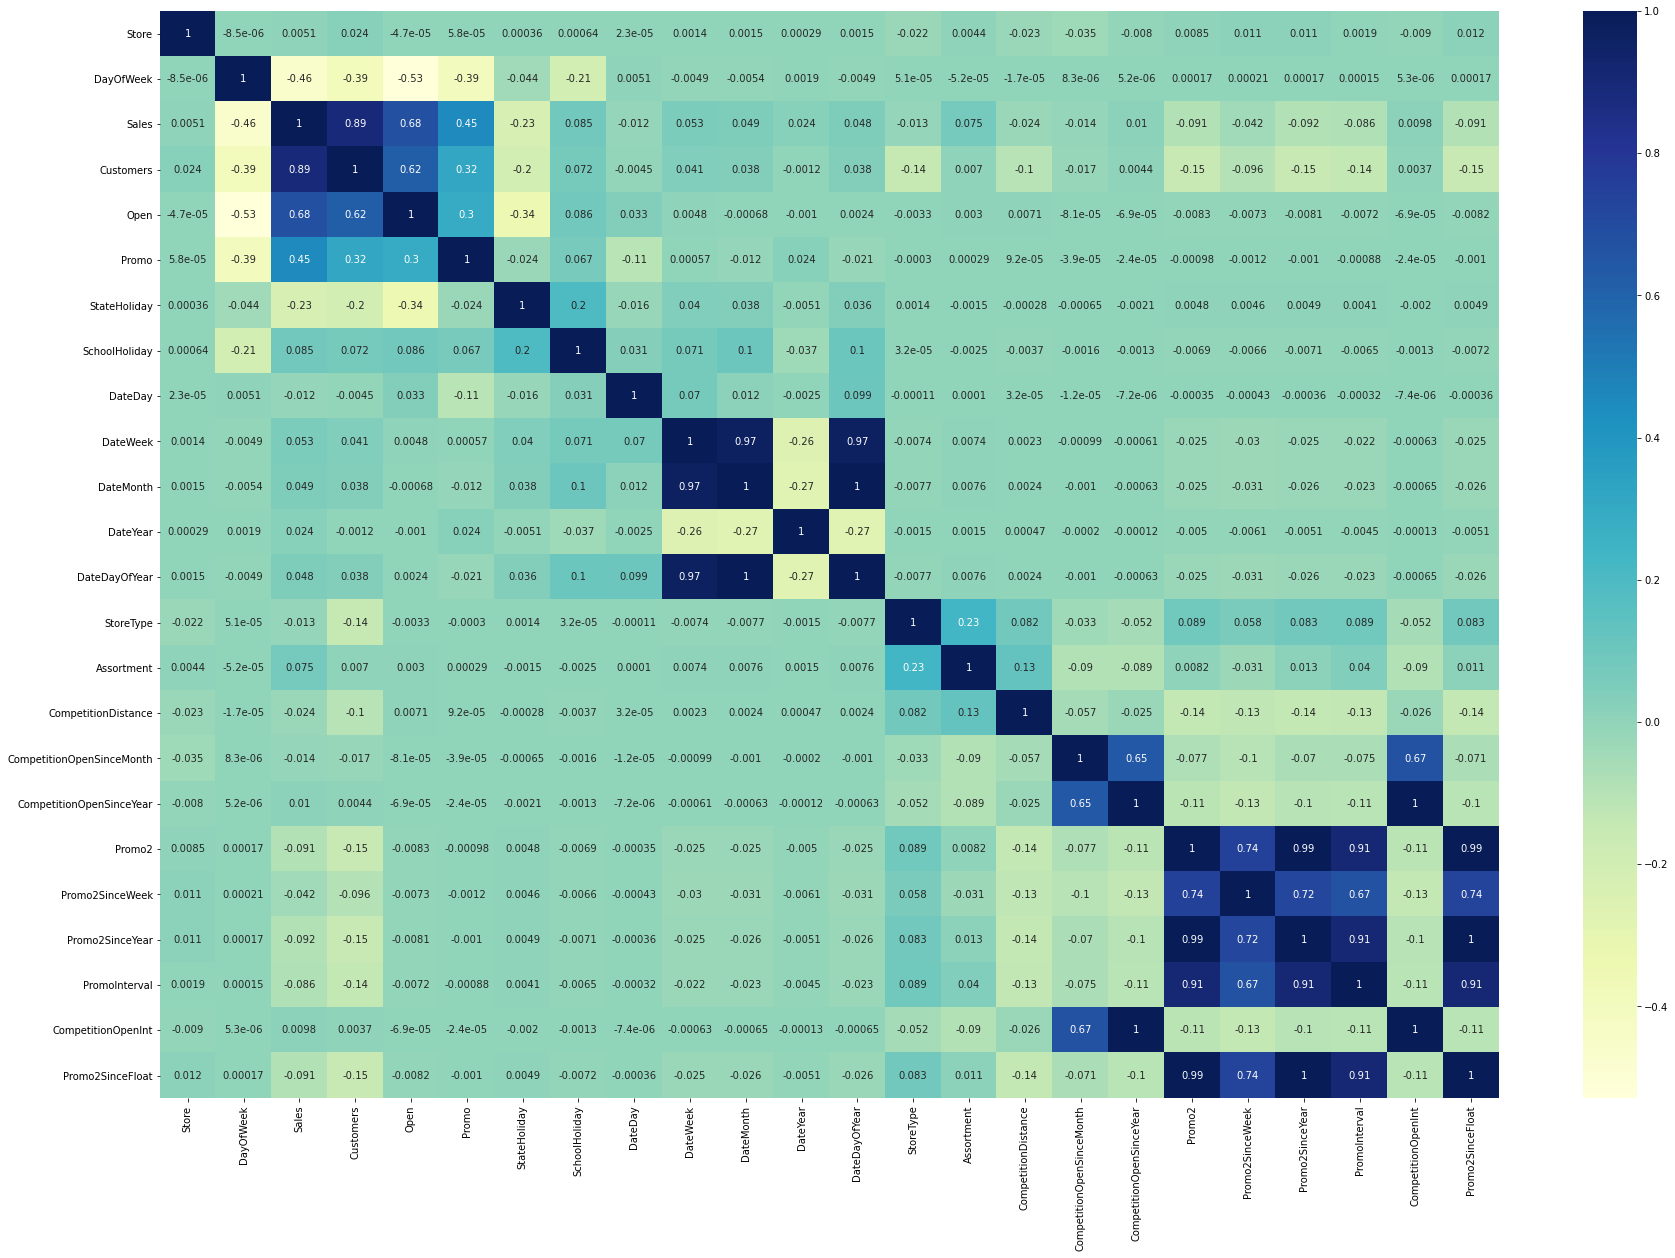

In [54]:
plt.figure(figsize=(30, 20))
sns.heatmap(joined_train.corr(),cmap="YlGnBu" ,annot=True);

In [55]:
#Se elimina esta columna porque no se tiene para test
columnasaEliminar=['Customers']
columnasaEliminar

['Customers']

In [56]:
joined_train = joined_train.drop(columns=columnasaEliminar,axis=1)
joined_train.columns

Index(['Store', 'DayOfWeek', 'Date', 'Sales', 'Open', 'Promo', 'StateHoliday', 'SchoolHoliday',
       'DateDay', 'DateWeek', 'DateMonth', 'DateYear', 'DateDayOfYear', 'StoreType', 'Assortment',
       'CompetitionDistance', 'CompetitionOpenSinceMonth', 'CompetitionOpenSinceYear', 'Promo2',
       'Promo2SinceWeek', 'Promo2SinceYear', 'PromoInterval', 'CompetitionOpenInt',
       'Promo2SinceFloat'],
      dtype='object')

In [57]:
joined_train.shape

(1017209, 24)

In [58]:
joined_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1017209 entries, 0 to 1017208
Data columns (total 24 columns):
 #   Column                     Non-Null Count    Dtype         
---  ------                     --------------    -----         
 0   Store                      1017209 non-null  int64         
 1   DayOfWeek                  1017209 non-null  int64         
 2   Date                       1017209 non-null  datetime64[ns]
 3   Sales                      1017209 non-null  int64         
 4   Open                       1017209 non-null  int64         
 5   Promo                      1017209 non-null  int64         
 6   StateHoliday               1017209 non-null  int8          
 7   SchoolHoliday              1017209 non-null  int64         
 8   DateDay                    1017209 non-null  int64         
 9   DateWeek                   1017209 non-null  int64         
 10  DateMonth                  1017209 non-null  int64         
 11  DateYear                   1017209 no

In [59]:
### Remove rows where store is open, but no sales.
joined_train = joined_train.loc[~((joined_train['Open'] == 1) & (joined_train['Sales'] == 0))]

In [60]:
joined_train.shape

(1017155, 24)

In [61]:
joined_train.reset_index(inplace=True)

In [62]:
joined_train.to_feather('all_preprocessed_cat_sales0_train.fth')

In [63]:
joined_test.reset_index(inplace=True)

In [64]:
joined_test.to_feather('all_preprocessed_cat_sales0_test.fth')

# Ejecuto modelo Baseline

In [65]:
features_x = ['Store', 'DayOfWeek', 'Open', 'Promo', 'StateHoliday', 'SchoolHoliday',
       'DateDay', 'DateWeek', 'DateMonth', 'DateYear', 'DateDayOfYear', 'StoreType', 'Assortment',
       'CompetitionDistance', 'CompetitionOpenSinceMonth', 'CompetitionOpenSinceYear', 'Promo2',
       'Promo2SinceWeek', 'Promo2SinceYear', 'PromoInterval', 'CompetitionOpenInt',
       'Promo2SinceFloat']
features_y = ['Sales']

In [66]:
### Convert every NAN to -1
for feature in features_x:
    joined_train[feature] = joined_train[feature].fillna(-1)

In [67]:
X_train, X_val, y_train, y_val = train_test_split(joined_train[features_x],
                                                    joined_train[features_y],
                                                    test_size=0.1, random_state=seed)

### XGB

In [68]:
n_estimators=4000
learning_rate=0.25
modelXGB = XGBRegressor(n_estimators=n_estimators, learning_rate=learning_rate, 
                 objective='reg:squarederror', n_jobs=12, max_depth=8, gamma=0.005)
print(modelXGB)

fit_params={"early_stopping_rounds":100, 
        "eval_metric" : 'rmse', 
        "eval_set" : [(X_val, y_val)],
        'verbose': 100,
       }

XGBRegressor(base_score=None, booster=None, colsample_bylevel=None,
             colsample_bynode=None, colsample_bytree=None, gamma=0.005,
             gpu_id=None, importance_type='gain', interaction_constraints=None,
             learning_rate=0.25, max_delta_step=None, max_depth=8,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=4000, n_jobs=12, num_parallel_tree=None,
             random_state=None, reg_alpha=None, reg_lambda=None,
             scale_pos_weight=None, subsample=None, tree_method=None,
             validate_parameters=None, verbosity=None)


In [69]:
modelXGB.fit(X_train, y_train, **fit_params)

[0]	validation_0-rmse:5407.39844
[100]	validation_0-rmse:880.97626
[200]	validation_0-rmse:751.10663
[300]	validation_0-rmse:695.17041
[400]	validation_0-rmse:664.29608
[500]	validation_0-rmse:644.32263
[600]	validation_0-rmse:630.83252
[700]	validation_0-rmse:622.20312
[800]	validation_0-rmse:616.08527
[900]	validation_0-rmse:611.06012
[1000]	validation_0-rmse:606.20374
[1100]	validation_0-rmse:603.31262
[1200]	validation_0-rmse:600.64136
[1300]	validation_0-rmse:598.76752
[1400]	validation_0-rmse:597.14093
[1500]	validation_0-rmse:595.60889
[1600]	validation_0-rmse:593.98706
[1700]	validation_0-rmse:592.94190
[1800]	validation_0-rmse:591.99335
[1900]	validation_0-rmse:591.41522
[2000]	validation_0-rmse:590.61847
[2100]	validation_0-rmse:589.82404
[2200]	validation_0-rmse:590.04584
[2201]	validation_0-rmse:590.06433


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0.005, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.25, max_delta_step=0, max_depth=8,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=4000, n_jobs=12, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [70]:
print('Score')
score = modelXGB.score(X_val, y_val)

X_submit = joined_test[features_x]

print('Comienzo Predict')
y_pred_train = modelXGB.predict(X_train)
y_pred_val = modelXGB.predict(X_val)
y_pred_test = modelXGB.predict(X_submit)

# Train
train_RMSE = np.sqrt((((y_train['Sales'].values - y_pred_train)/y_train['Sales'].values)**2).sum()/len(y_pred_train))
# Validación
val_RMSE = np.sqrt((((y_val['Sales'].values - y_pred_val)/y_val['Sales'].values)**2).sum()/len(y_pred_val))

print('Score, train_RMSE, val_RMSE')
print(score, train_RMSE, val_RMSE)


sample_csv = pd.read_csv('dataset/rossmann/sample_submission.csv')
sample_csv['Sales'] = y_pred_test
sample_csv.head()
sample_csv.to_csv(f'submision_XGBBaseline.csv', index=False)

Score
Comienzo Predict
Score, train_RMSE, val_RMSE
0.9763044252766888 inf inf


In [75]:
y_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 915439 entries, 360498 to 121958
Data columns (total 1 columns):
 #   Column  Non-Null Count   Dtype
---  ------  --------------   -----
 0   Sales   915439 non-null  int64
dtypes: int64(1)
memory usage: 14.0 MB


<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

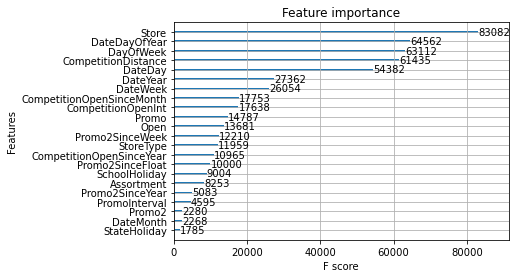

In [73]:
xgb.plot_importance(modelXGB)

submision_XGBBaseline.csv
Private Score: 0.15162
Public Score: 0.13718

# Se hacen otros procesamientos en los datos para mejorar el resultado

In [ ]:
#joined_train = pd.read_feather('all_preprocessed_cat_sales0_train.fth')
#joined_test = pd.read_feather('all_preprocessed_cat_sales0_test.fth')

In [87]:
joined_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1017155 entries, 0 to 1017154
Data columns (total 25 columns):
 #   Column                     Non-Null Count    Dtype         
---  ------                     --------------    -----         
 0   index                      1017155 non-null  int64         
 1   Store                      1017155 non-null  int64         
 2   DayOfWeek                  1017155 non-null  int64         
 3   Date                       1017155 non-null  datetime64[ns]
 4   Sales                      1017155 non-null  int64         
 5   Open                       1017155 non-null  int64         
 6   Promo                      1017155 non-null  int64         
 7   StateHoliday               1017155 non-null  int8          
 8   SchoolHoliday              1017155 non-null  int64         
 9   DateDay                    1017155 non-null  int64         
 10  DateWeek                   1017155 non-null  int64         
 11  DateMonth                  1017155 no

In [88]:
#se trabaja con algunas variables
features_x = ['Store', 'DayOfWeek', 'Open', 'Promo', 'SchoolHoliday', 'StateHoliday', 'StoreType', 'Assortment', 
                  'CompetitionDistance', 'CompetitionOpenInt', 'PromoInterval']
features_y = ['SalesLog']

In [89]:
#Se agregan variables referidas a la fecha
var_name = 'Date'
features_x.append(var_name + 'Day')
features_x.append(var_name + 'Week')
features_x.append(var_name + 'Month')
features_x.append(var_name + 'Year')
features_x.append(var_name + 'DayOfYear')

In [90]:
#se utiliza el log de sales
joined_train['SalesLog'] = np.log1p(joined_train['Sales']) 

In [91]:
joined_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1017155 entries, 0 to 1017154
Data columns (total 26 columns):
 #   Column                     Non-Null Count    Dtype         
---  ------                     --------------    -----         
 0   index                      1017155 non-null  int64         
 1   Store                      1017155 non-null  int64         
 2   DayOfWeek                  1017155 non-null  int64         
 3   Date                       1017155 non-null  datetime64[ns]
 4   Sales                      1017155 non-null  int64         
 5   Open                       1017155 non-null  int64         
 6   Promo                      1017155 non-null  int64         
 7   StateHoliday               1017155 non-null  int8          
 8   SchoolHoliday              1017155 non-null  int64         
 9   DateDay                    1017155 non-null  int64         
 10  DateWeek                   1017155 non-null  int64         
 11  DateMonth                  1017155 no

## Remove Outliers with Deviation >= 3

In [92]:
def is_outlier(points, thresh=3.5):
    """
    Returns a boolean array with True if points are outliers and False 
    otherwise.

    Parameters:
    -----------
        points : An numobservations by numdimensions array of observations
        thresh : The modified z-score to use as a threshold. Observations with
            a modified z-score (based on the median absolute deviation) greater
            than this value will be classified as outliers.

    Returns:
    --------
        mask : A numobservations-length boolean array.

    References:
    ----------
        Boris Iglewicz and David Hoaglin (1993), "Volume 16: How to Detect and
        Handle Outliers", The ASQC Basic References in Quality Control:
        Statistical Techniques, Edward F. Mykytka, Ph.D., Editor. 
    """
    if len(points.shape) == 1:
        points = points[:,None]
    median = np.median(points, axis=0)
    diff = np.sum((points - median)**2, axis=-1)
    diff = np.sqrt(diff)
    med_abs_deviation = np.median(diff)

    modified_z_score = 0.6745 * diff / med_abs_deviation

    return modified_z_score > thresh

In [93]:
for i in joined_train['Store'].unique():
    joined_train.loc[(joined_train['Store'] == i) & (joined_train['Open'] == 1), 'Outlier'] = \
        is_outlier(joined_train.loc[(joined_train['Store'] == i) & (joined_train['Open'] == 1)]['Sales'], 3)

In [94]:
joined_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1017155 entries, 0 to 1017154
Data columns (total 27 columns):
 #   Column                     Non-Null Count    Dtype         
---  ------                     --------------    -----         
 0   index                      1017155 non-null  int64         
 1   Store                      1017155 non-null  int64         
 2   DayOfWeek                  1017155 non-null  int64         
 3   Date                       1017155 non-null  datetime64[ns]
 4   Sales                      1017155 non-null  int64         
 5   Open                       1017155 non-null  int64         
 6   Promo                      1017155 non-null  int64         
 7   StateHoliday               1017155 non-null  int8          
 8   SchoolHoliday              1017155 non-null  int64         
 9   DateDay                    1017155 non-null  int64         
 10  DateWeek                   1017155 non-null  int64         
 11  DateMonth                  1017155 no

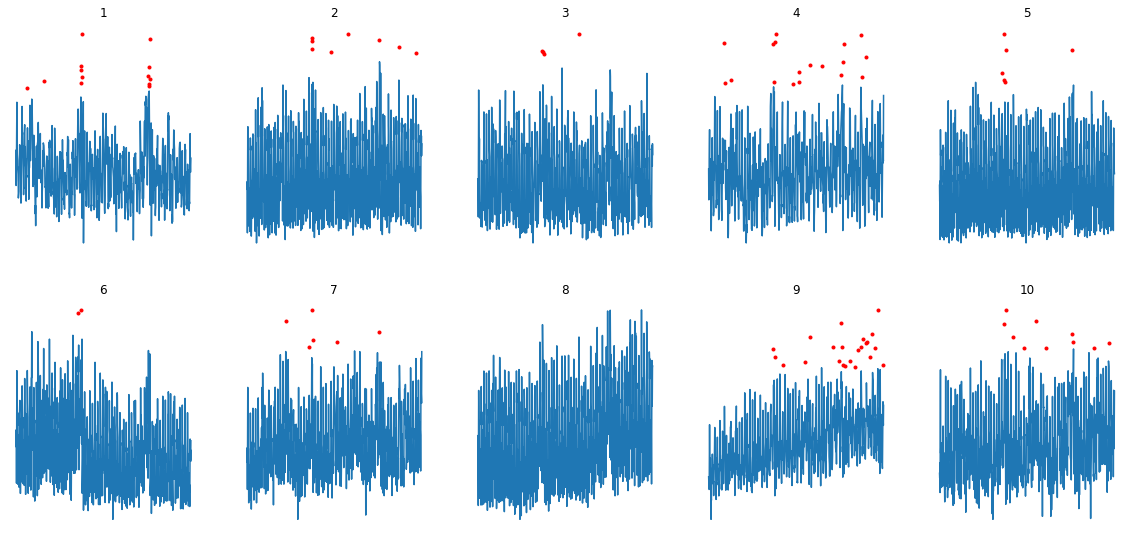

In [95]:
no_stores_to_check = 10

plt.rcParams["figure.figsize"] = [20,no_stores_to_check*5]

for i in range(1,no_stores_to_check+1):
    stor = i

    # Normal sales
    X1 = joined_train.loc[(joined_train['Store'] == stor) & (joined_train['Open'] == 1) & (joined_train['Outlier'] == False)]
    y1 = joined_train.loc[(joined_train['Store'] == stor) & (joined_train['Open'] == 1) & (joined_train['Outlier'] == False)]['Sales']

    # Outliers
    X2 = joined_train.loc[(joined_train['Store'] == stor) & (joined_train['Open'] == 1) & (joined_train['Outlier'] == True)]
    y2 = joined_train.loc[(joined_train['Store'] == stor) & (joined_train['Open'] == 1) & (joined_train['Outlier'] == True)]['Sales']

    Xt = joined_train.loc[(joined_train['Store'] == stor)]
    
    plt.subplot(10,5,i)
    plt.plot(X1['Date'], y1, '-')
    plt.plot(X2['Date'], y2, 'r.')
    plt.title(i)
    plt.axis('off')

# Se vuelve a ejecutar el modelo XGB

In [96]:
X_train, X_val, y_train, y_val = train_test_split(joined_train.loc[(joined_train['Open'] == 1) & (joined_train['Outlier'] == False)][features_x],
                                                    joined_train.loc[(joined_train['Open'] == 1) & (joined_train['Outlier'] == False)][features_y],
                                                    test_size=0.1, random_state=seed)

In [97]:
n_estimators=4000
learning_rate=0.25
modelXGB = XGBRegressor(n_estimators=n_estimators, learning_rate=learning_rate, 
                 objective='reg:squarederror', n_jobs=12, max_depth=8, gamma=0.005)
print(modelXGB)

fit_params={"early_stopping_rounds":100, 
            "eval_metric" : 'rmse', 
            "eval_set" : [(X_val, y_val)],
            'verbose': 100,
           }

XGBRegressor(base_score=None, booster=None, colsample_bylevel=None,
             colsample_bynode=None, colsample_bytree=None, gamma=0.005,
             gpu_id=None, importance_type='gain', interaction_constraints=None,
             learning_rate=0.25, max_delta_step=None, max_depth=8,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=4000, n_jobs=12, num_parallel_tree=None,
             random_state=None, reg_alpha=None, reg_lambda=None,
             scale_pos_weight=None, subsample=None, tree_method=None,
             validate_parameters=None, verbosity=None)


In [98]:
print(features_x)
print(features_y)

['Store', 'DayOfWeek', 'Open', 'Promo', 'SchoolHoliday', 'StateHoliday', 'StoreType', 'Assortment', 'CompetitionDistance', 'CompetitionOpenInt', 'PromoInterval', 'DateDay', 'DateWeek', 'DateMonth', 'DateYear', 'DateDayOfYear']
['SalesLog']


In [99]:
X_train.shape

(748223, 16)

In [100]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 748223 entries, 93461 to 150769
Data columns (total 16 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   Store                748223 non-null  int64  
 1   DayOfWeek            748223 non-null  int64  
 2   Open                 748223 non-null  int64  
 3   Promo                748223 non-null  int64  
 4   SchoolHoliday        748223 non-null  int64  
 5   StateHoliday         748223 non-null  int8   
 6   StoreType            748223 non-null  int8   
 7   Assortment           748223 non-null  int8   
 8   CompetitionDistance  748223 non-null  float64
 9   CompetitionOpenInt   748223 non-null  int64  
 10  PromoInterval        748223 non-null  int8   
 11  DateDay              748223 non-null  int64  
 12  DateWeek             748223 non-null  int64  
 13  DateMonth            748223 non-null  int64  
 14  DateYear             748223 non-null  int64  
 15  DateDayOfYear

In [101]:
X_train.head(5)

,Store,DayOfWeek,Open,Promo,SchoolHoliday,StateHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenInt,PromoInterval,DateDay,DateWeek,DateMonth,DateYear,DateDayOfYear
93461,918,6,1,0,0,0,0,2,18710.0,1427846400000000000,0,9,19,5,2015,129
206818,547,2,1,1,0,0,3,2,8990.0,1257033600000000000,3,27,5,1,2015,27
356489,527,1,1,0,0,0,3,2,5830.0,1207008000000000000,0,25,35,8,2014,237
621822,473,6,1,0,0,0,0,0,50.0,631152000000000000,0,21,51,12,2013,355
805940,620,2,1,0,0,0,3,2,5440.0,631152000000000000,2,9,28,7,2013,190


In [102]:
y_train.shape

(748223, 1)

In [103]:
y_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 748223 entries, 93461 to 150769
Data columns (total 1 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   SalesLog  748223 non-null  float64
dtypes: float64(1)
memory usage: 11.4 MB


In [104]:
y_train.head(5)

,SalesLog
93461,8.163086
206818,8.431635
356489,9.170247
621822,8.304000
805940,8.660081


In [105]:
modelXGB.fit(X_train, y_train, **fit_params)

[0]	validation_0-rmse:6.19760
[100]	validation_0-rmse:0.12356
[200]	validation_0-rmse:0.10303
[300]	validation_0-rmse:0.09581
[400]	validation_0-rmse:0.09222
[500]	validation_0-rmse:0.09012
[600]	validation_0-rmse:0.08876
[700]	validation_0-rmse:0.08793
[800]	validation_0-rmse:0.08727
[900]	validation_0-rmse:0.08678
[1000]	validation_0-rmse:0.08640
[1100]	validation_0-rmse:0.08610
[1200]	validation_0-rmse:0.08597
[1300]	validation_0-rmse:0.08584
[1400]	validation_0-rmse:0.08570
[1500]	validation_0-rmse:0.08557
[1600]	validation_0-rmse:0.08551
[1700]	validation_0-rmse:0.08543
[1800]	validation_0-rmse:0.08538
[1900]	validation_0-rmse:0.08534
[2000]	validation_0-rmse:0.08534
[2071]	validation_0-rmse:0.08536


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0.005, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.25, max_delta_step=0, max_depth=8,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=4000, n_jobs=12, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [106]:
score = modelXGB.score(X_val, y_val)

In [107]:
X_submit = joined_test[features_x]

In [108]:
y_pred_train = np.exp(modelXGB.predict(X_train))
y_pred_val = np.exp(modelXGB.predict(X_val))
y_pred_test = np.exp(modelXGB.predict(X_submit))

In [109]:
# Train
train_RMSE = np.sqrt((((y_train['SalesLog'].values - np.log1p(y_pred_train))/y_train['SalesLog'].values)**2).sum()/len(y_pred_train))
# Validación
val_RMSE = np.sqrt((((y_val['SalesLog'].values - np.log1p(y_pred_val))/y_val['SalesLog'].values)**2).sum()/len(y_pred_val))

In [110]:
print(score, train_RMSE, val_RMSE)

0.9584268615457237 0.006950153670063918 0.01002622312033552


<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

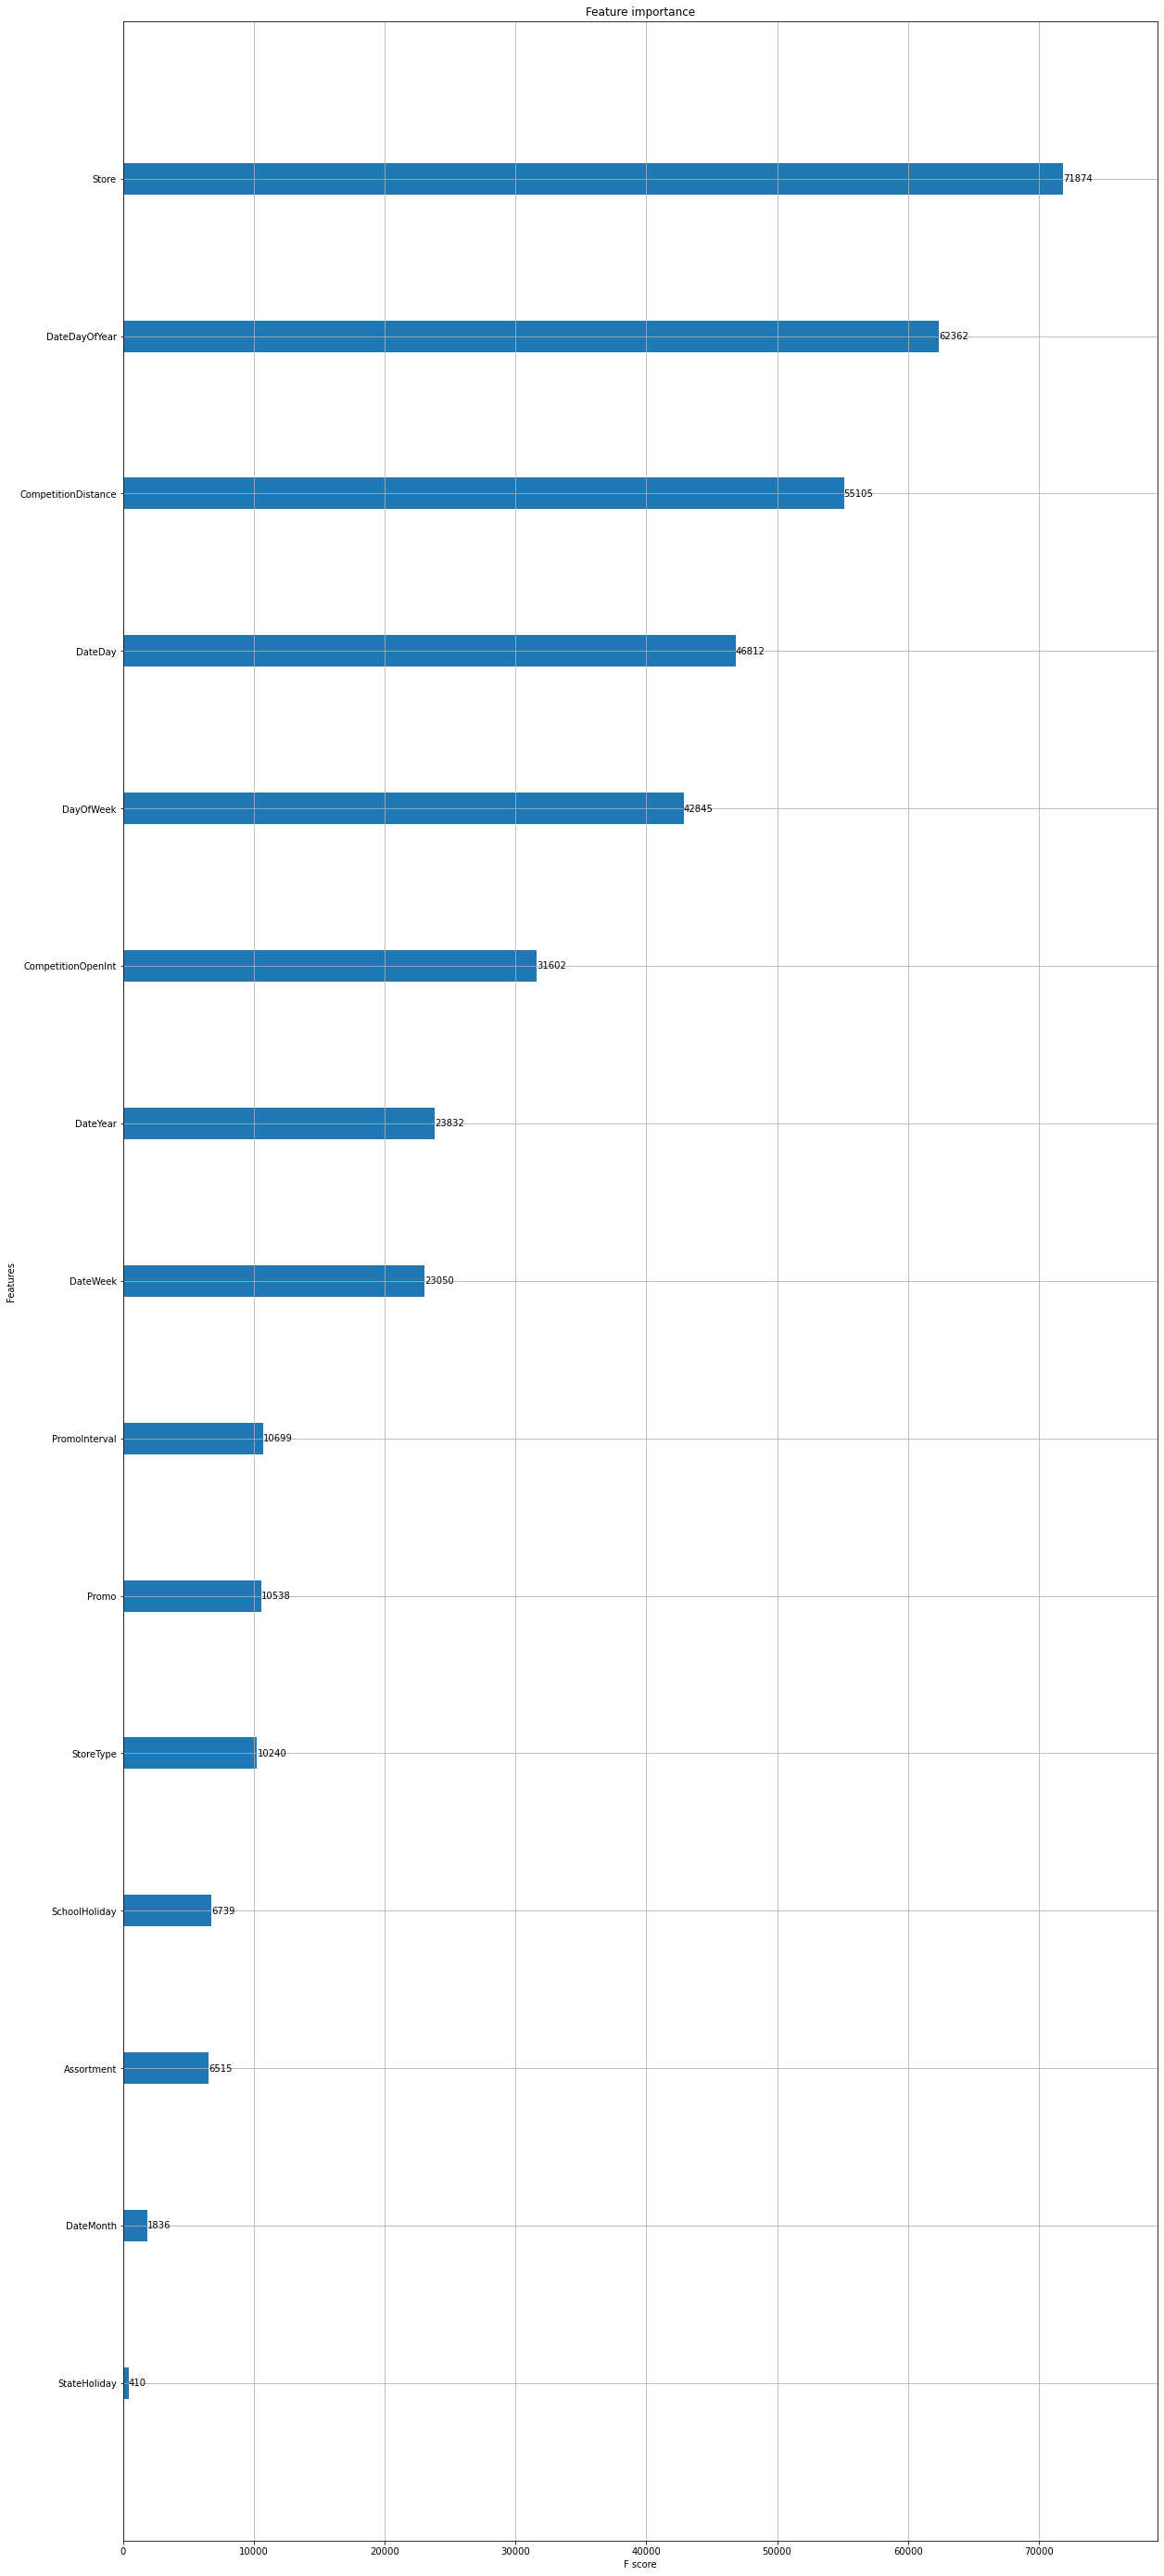

In [112]:
xgb.plot_importance(modelXGB)

In [113]:
sample_csv = pd.read_csv('dataset/rossmann/sample_submission.csv')
sample_csv['Sales'] = y_pred_test
sample_csv.head()

sample_csv.to_csv(f'submision_XGBProcesado.csv', index=False)

Private score: 0.12048
Public Score: 0.11426